## Data Loading and Preprocessing

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.simplefilter("ignore", category=UserWarning)

import os
os.environ['OMP_NUM_THREADS'] = '1'


In [2]:


#  dataset
df = pd.read_csv('updated_dataset.csv')

#  date columns to datetime
date_columns = ['Date of Admission', 'Date of Hospital Discharge', 'PEG ORDERS PLACED', 'TRACH ORDERS PLACED', 'PEG DATE', 'TRACH DATE', 'Date Decannulation', 'Date of oral intake']
for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Drop rows where 'Hospital LOS Days' is less than 0
df = df[df['Hospital LOS Days'] >= 0]

#  differences in days
df['PEG_Duration'] = (df['Date of oral intake'] - df['PEG DATE']).dt.days
df['PEG_Days_Difference'] = (df['PEG DATE'] - df['PEG ORDERS PLACED']).dt.days
df['PEG_ORDER_to_ADMISSION'] = (df['PEG ORDERS PLACED'] - df['Date of Admission']).dt.days
df['Trach_ORDER_to_ADMISSION'] = (df['TRACH ORDERS PLACED'] - df['Date of Admission']).dt.days
df['Trach_Days_Difference'] = (df['TRACH DATE'] - df['TRACH ORDERS PLACED']).dt.days
df['Trach_Duration'] = (df['Date Decannulation'] - df['TRACH DATE']).dt.days

# Categorize 'Hospital LOS'
df['Hospital_LOS_Category'] = pd.cut(df['Hospital LOS Days'],
                                         bins=[-np.inf, 24, np.inf],
                                         labels=[0, 1])


# Selected features
features = ['Age', 'Gender', 'Race', 'BMI', 'PEG', 'TRACH', 'GCS', 
            'GCS Qualifier', 'ISS', 'Charlson_Comorbidity_Index'
            ]
df = df.dropna(subset=['GCS', 'GCS Qualifier'])
X = df[features]
y = df['Hospital_LOS_Category']

# Encode categorical features
categorical_features = ['Gender', 'Race', 'PEG', 'TRACH', 'GCS Qualifier']
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Age', 'BMI', 'GCS', 'ISS', 'Charlson_Comorbidity_Index']),
        ('cat', OneHotEncoder(), categorical_features)])


In [3]:
y.value_counts()

Hospital_LOS_Category
1    189
0     57
Name: count, dtype: int64

## XGBoost

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from xgboost import XGBClassifier

# XGBoost model
model = XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    n_jobs=-1,
    random_state=42
)

# Pipeline including SMOTE 
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('model', model)
])

#  GridSearchCV 
param_grid = {
    'model__n_estimators': [50, 100, 200, 500],
    'model__learning_rate': [0.001, 0.01, 0.1, 0.3],
    'model__max_depth': [3, 5, 7, 10],
    # 'model__min_child_weight': [1, 3, 5, 7],
    'model__gamma': [0, 0.1, 0.2, 0.3],
    'model__subsample': [0.6, 1.0],
    # 'model__colsample_bytree': [0.6, 0.8, 1.0],
    'model__reg_alpha': [0, 0.01, 0.1, 1],
    'model__reg_lambda': [0.1, 1, 10]
}

#  StratifiedKFold cross-validator
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#  grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search.fit(X, y)

best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")


# Evaluate 
y_pred = grid_search.predict(X)
print("Classification Report:")
print(classification_report(y, y_pred))


roc_auc = roc_auc_score(y, grid_search.predict_proba(X)[:, 1])
print(f"AUC Score: {roc_auc:.4f}")


f1 = f1_score(y, y_pred, average='weighted')
print(f"F1 Score: {f1:.4f}")


print("Confusion Matrix:")
print(confusion_matrix(y, y_pred))


Fitting 5 folds for each of 6144 candidates, totalling 30720 fits
Best Parameters: {'model__gamma': 0, 'model__learning_rate': 0.1, 'model__max_depth': 7, 'model__n_estimators': 50, 'model__reg_alpha': 0.1, 'model__reg_lambda': 10, 'model__subsample': 0.6}
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.81      0.75        57
           1       0.94      0.89      0.92       189

    accuracy                           0.87       246
   macro avg       0.82      0.85      0.83       246
weighted avg       0.88      0.87      0.88       246

AUC Score: 0.9478
F1 Score: 0.8771
Confusion Matrix:
[[ 46  11]
 [ 20 169]]


In [5]:
from sklearn.metrics import balanced_accuracy_score

balanced_acc = balanced_accuracy_score(y, y_pred)
print(f"Balanced Accuracy: {balanced_acc:.4f}")


Balanced Accuracy: 0.8506


Precision-Recall AUC: 0.9850


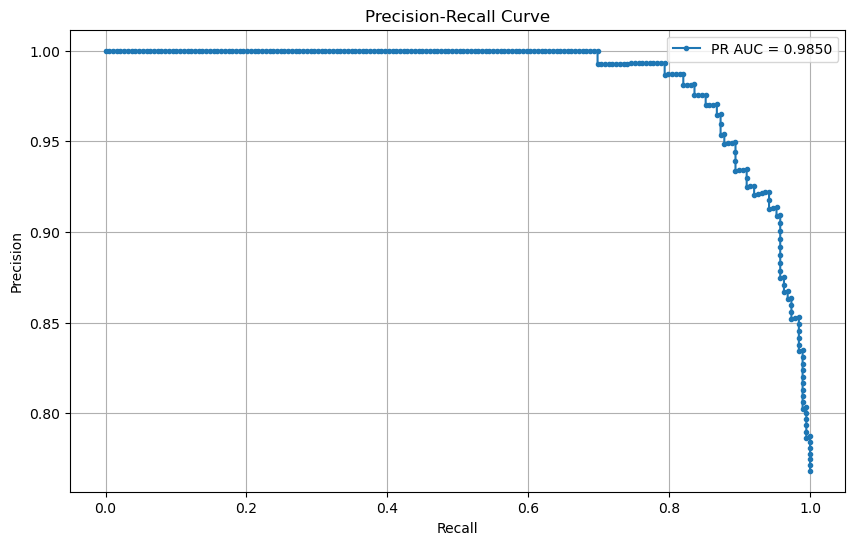

ROC AUC: 0.9478


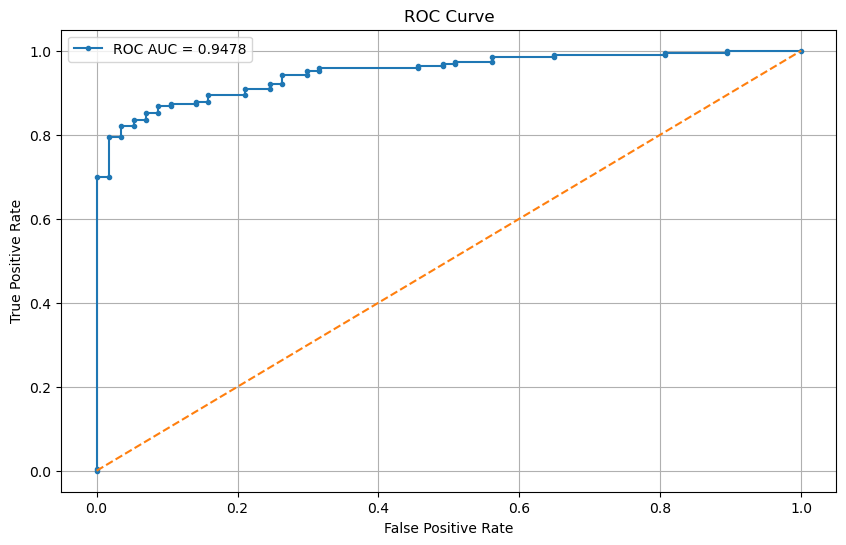

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, auc

#  probabilities for the positive class
y_scores = grid_search.predict_proba(X)[:, 1]

# Precision-Recall AUC
precision, recall, _ = precision_recall_curve(y, y_scores)
pr_auc = average_precision_score(y, y_scores)
print(f"Precision-Recall AUC: {pr_auc:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, marker='.', label=f'PR AUC = {pr_auc:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()

# ROC-AUC
fpr, tpr, _ = roc_curve(y, y_scores)
roc_auc = auc(fpr, tpr)
print(f"ROC AUC: {roc_auc:.4f}")


plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, marker='.', label=f'ROC AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()


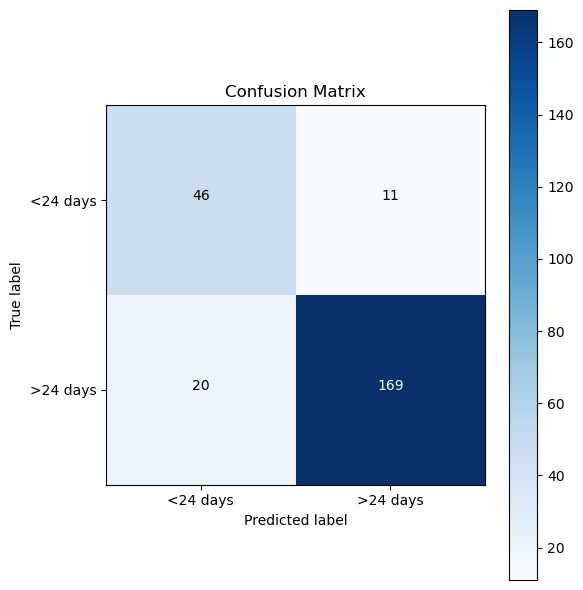

In [7]:
import matplotlib.pyplot as plt
import numpy as np

#  confusion matrix values
cm = np.array([[46, 11],
               [20, 169]])

plt.figure(figsize=(6, 6))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(2)
plt.xticks(tick_marks, ['<24 days', '>24 days'], rotation=0)
plt.yticks(tick_marks, ['<24 days', '>24 days'])

thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()


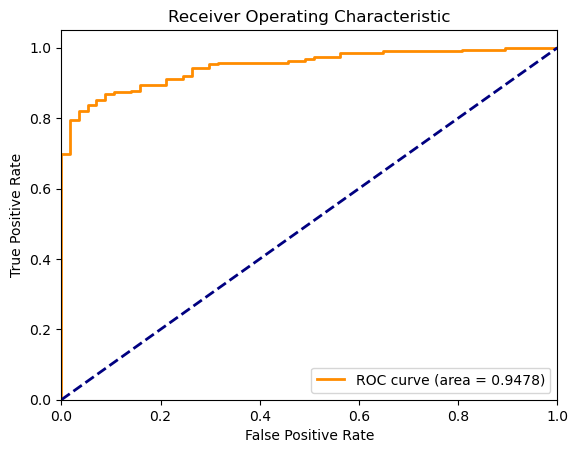

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

#  ROC curve
fpr, tpr, _ = roc_curve(y, grid_search.predict_proba(X)[:, 1])


plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
